In [172]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000) 
pd.set_option('display.max_columns', 1000) 

In [187]:
#load datasets
df_train = pd.read_csv(r'F:\DS\Kernel\data\train.csv')
df_test = pd.read_csv(r'F:\DS\Kernel\data\test.csv')
# drop duplicates from train
df_train = df_train.drop_duplicates()
df_train.shape, df_test.shape

((5687, 162), (2192, 162))

#### Here I will prepare the dataset for the next step - training the model

In [124]:
def predecessor(df):
    """
    This function preprocesses the given dataframe by creating binary features for each unique value in the 'Predecessor'
    column (Pred_0 to Pred_5). It then removes the 'Predecessor' column and aggregates any duplicate rows based on
    specific columns, ensuring that all information about predecessors is retained in the binary features. The function
    returns a dataframe with unique rows for each 'Field' and additional binary 'Pred_' columns.
    """
    # Create new features Pred_0 ... Pred_5 and initialize them with zeros
    for i in range(5):
        df['Pred_' + str(i)] = np.where(df['Predecessor'] == i, 1, 0)

    # Remove the 'Predecessor' column
    df.drop('Predecessor', axis=1, inplace=True)

    # Define columns for aggregation
    dedup_cols = ['Field', 'Year', 'Cluster', 'Area', 'Yield', 'Geozone']
    agg_dict = {col: 'max' for col in df.columns if col.startswith('Pred_')}
    
    # For all other columns except those used for identifying duplicates, use the first value
    for col in df.columns:
        if col not in dedup_cols and not col.startswith('Pred_'):
            agg_dict[col] = 'first'

    # Aggregate data so that each unique field has only one row
    df = df.groupby(dedup_cols).agg(agg_dict).reset_index()

    return df

In [125]:
def FAO_to_categories(df, column_name, categories):
    """
    Converts a numeric column FAO in the dataframe into binary categorical features based on provided categories include NaN.
    """
    
    # Ensure the column is of type string
    df[column_name] = df[column_name].astype(str)
    

    # Create binary columns for each sorted category
    for val in sorted(categories, key=lambda x: (x != 'nan', x)):  # Sort categories, placing 'nan' at the end
        if val == 'nan':
            column_name_new = 'FAO_NaN'
        else:
            column_name_new = 'FAO_' + val.split('.')[0]  # Removing the decimal part for the column name
        df[column_name_new] = np.where(df[column_name] == val, 1, 0)
    
    # Remove the original column
    df.drop(column_name, axis=1, inplace=True)
    
    return df

In [188]:
df_train = predecessor(df_train)
df_test = predecessor(df_test)
unique_categories_fao = df_train['FAO'].astype(str).unique()
df_train = FAO_to_categories(df_train, 'FAO', unique_categories_fao)
df_test = FAO_to_categories(df_test, 'FAO', unique_categories_fao)
df_train.shape, df_test.shape

((5561, 188), (2187, 188))

I decide to fill in the missed values in fertilizers (P_kg/ga, K_kg/ga) features based on the median value for the Geozone

In [189]:
df_train['P_kg/ga'] = df_train.groupby('Geozone')['P_kg/ga'].transform(lambda x: x.fillna(x.median()))
df_train['K_kg/ga'] = df_train.groupby('Geozone')['K_kg/ga'].transform(lambda x: x.fillna(x.median()))

df_test['P_kg/ga'] = df_test.groupby('Geozone')['P_kg/ga'].transform(lambda x: x.fillna(x.median()))
df_test['K_kg/ga'] = df_test.groupby('Geozone')['K_kg/ga'].transform(lambda x: x.fillna(x.median()))
df_train.shape, df_test.shape

((5561, 188), (2187, 188))

In [176]:
def expand_geozone_feature(df, column_name='Geozone'):
    """
    This function takes a DataFrame and a column name ('Geozone') and generates binary features ('Geo_0' to 'Geo_42')
    for each unique category in the column. It then removes the original 'Geozone' column from the DataFrame.
    """
    
    # Check if the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"The column {column_name} does not exist in the DataFrame.")
    
    # Create binary features for each category in the 'Geozone' column
    for i in range(43):  # Assuming categories go from 0 to 42
        new_col_name = f'Geo_{i}'
        df[new_col_name] = (df[column_name] == i).astype(int)
    
    # Remove the original 'Geozone' column
    df.drop(column_name, axis=1, inplace=True)
    
    return df

We are missing 42 Geozone in the training dataset, however, I decided not to exclude this Geozone from the forecast, and also, as part of this task, not to select a suitable existing Geozone based on climatic characteristics, which would probably need to be done in real conditions.

In [190]:
df_train = expand_geozone_feature(df_train, 'Geozone')
df_test = expand_geozone_feature(df_test, 'Geozone')
df_train.shape, df_test.shape

((5561, 230), (2187, 230))

In [135]:
def expand_cluster_feature(df, column_name='Cluster'):
    """
    This function takes a DataFrame and a column name ('Cluster') and generates binary features ('Cluster_0' to 'Cluster_6')
    for each unique category in the column. It then removes the original 'Cluster' column from the DataFrame.

    """
    
    # Check if the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"The column {column_name} does not exist in the DataFrame.")
    
    # Create binary features for each category in the 'Cluster' column
    for i in range(7):  # Assuming categories go from 0 to 6
        new_col_name = f'Cluster_{i}'
        df[new_col_name] = (df[column_name] == i).astype(int)
    
    # Remove the original 'Cluster' column
    df.drop(column_name, axis=1, inplace=True)
    
    return df

In [191]:
df_train = expand_cluster_feature(df_train, 'Cluster')
df_test = expand_cluster_feature(df_test, 'Cluster')
df_train.shape, df_test.shape

((5561, 236), (2187, 236))

Due to the large number of outliers of the Area feature, I add an additional feature, which will provide for a logarithmic transformation of the Area.
I do the same for the Yield feature

In [192]:
df_train['logArea'] = df_train.Area.apply(np.log1p)
df_test['logArea'] = df_test.Area.apply(np.log1p)

df_train['logYield'] = df_train.Yield.apply(np.log1p)
df_test['logYield'] = df_test.Yield.apply(np.log1p)
df_train.shape, df_test.shape

((5561, 238), (2187, 238))

In [180]:
df_test.sample(5)

,Field,Year,Area,Yield,Pred_0,Pred_1,Pred_2,Pred_3,Pred_4,N_kg/ga,P_kg/ga,K_kg/ga,5_YEARLY_median_AVERAGE_TEMPERATURE,6_YEARLY_median_AVERAGE_TEMPERATURE,7_YEARLY_median_AVERAGE_TEMPERATURE,8_YEARLY_median_AVERAGE_TEMPERATURE,9_YEARLY_median_AVERAGE_TEMPERATURE,5_YEARLY_median_EVAPORATION,6_YEARLY_median_EVAPORATION,7_YEARLY_median_EVAPORATION,8_YEARLY_median_EVAPORATION,9_YEARLY_median_EVAPORATION,5_YEARLY_median_HUMIDITY(%),6_YEARLY_median_HUMIDITY(%),7_YEARLY_median_HUMIDITY(%),8_YEARLY_median_HUMIDITY(%),9_YEARLY_median_HUMIDITY(%),5_YEARLY_sum_CALCULATED_RADIATION,6_YEARLY_sum_CALCULATED_RADIATION,7_YEARLY_sum_CALCULATED_RADIATION,8_YEARLY_sum_CALCULATED_RADIATION,9_YEARLY_sum_CALCULATED_RADIATION,5_YEARLY_sum_RAINFALL,6_YEARLY_sum_RAINFALL,7_YEARLY_sum_RAINFALL,8_YEARLY_sum_RAINFALL,9_YEARLY_sum_RAINFALL,22_WEEK_AVERAGE_TEMPERATURE,23_WEEK_AVERAGE_TEMPERATURE,24_WEEK_AVERAGE_TEMPERATURE,25_WEEK_AVERAGE_TEMPERATURE,26_WEEK_AVERAGE_TEMPERATURE,27_WEEK_AVERAGE_TEMPERATURE,28_WEEK_AVERAGE_TEMPERATURE,29_WEEK_AVERAGE_TEMPERATURE,30_WEEK_AVERAGE_TEMPERATURE,31_WEEK_AVERAGE_TEMPERATURE,32_WEEK_AVERAGE_TEMPERATURE,33_WEEK_AVERAGE_TEMPERATURE,34_WEEK_AVERAGE_TEMPERATURE,35_WEEK_AVERAGE_TEMPERATURE,36_WEEK_AVERAGE_TEMPERATURE,37_WEEK_AVERAGE_TEMPERATURE,38_WEEK_AVERAGE_TEMPERATURE,39_WEEK_AVERAGE_TEMPERATURE,22_WEEK_CALCULATED_RADIATION,23_WEEK_CALCULATED_RADIATION,24_WEEK_CALCULATED_RADIATION,25_WEEK_CALCULATED_RADIATION,26_WEEK_CALCULATED_RADIATION,27_WEEK_CALCULATED_RADIATION,28_WEEK_CALCULATED_RADIATION,29_WEEK_CALCULATED_RADIATION,30_WEEK_CALCULATED_RADIATION,31_WEEK_CALCULATED_RADIATION,32_WEEK_CALCULATED_RADIATION,33_WEEK_CALCULATED_RADIATION,34_WEEK_CALCULATED_RADIATION,35_WEEK_CALCULATED_RADIATION,36_WEEK_CALCULATED_RADIATION,37_WEEK_CALCULATED_RADIATION,38_WEEK_CALCULATED_RADIATION,39_WEEK_CALCULATED_RADIATION,22_WEEK_EVAPORATION,23_WEEK_EVAPORATION,24_WEEK_EVAPORATION,25_WEEK_EVAPORATION,26_WEEK_EVAPORATION,27_WEEK_EVAPORATION,28_WEEK_EVAPORATION,29_WEEK_EVAPORATION,30_WEEK_EVAPORATION,31_WEEK_EVAPORATION,32_WEEK_EVAPORATION,33_WEEK_EVAPORATION,34_WEEK_EVAPORATION,35_WEEK_EVAPORATION,36_WEEK_EVAPORATION,37_WEEK_EVAPORATION,38_WEEK_EVAPORATION,39_WEEK_EVAPORATION,22_WEEK_HUMIDITY(%),23_WEEK_HUMIDITY(%),24_WEEK_HUMIDITY(%),25_WEEK_HUMIDITY(%),26_WEEK_HUMIDITY(%),27_WEEK_HUMIDITY(%),28_WEEK_HUMIDITY(%),29_WEEK_HUMIDITY(%),30_WEEK_HUMIDITY(%),31_WEEK_HUMIDITY(%),32_WEEK_HUMIDITY(%),33_WEEK_HUMIDITY(%),34_WEEK_HUMIDITY(%),35_WEEK_HUMIDITY(%),36_WEEK_HUMIDITY(%),37_WEEK_HUMIDITY(%),38_WEEK_HUMIDITY(%),39_WEEK_HUMIDITY(%),22_WEEK_RAINFALL,23_WEEK_RAINFALL,24_WEEK_RAINFALL,25_WEEK_RAINFALL,26_WEEK_RAINFALL,27_WEEK_RAINFALL,28_WEEK_RAINFALL,29_WEEK_RAINFALL,30_WEEK_RAINFALL,31_WEEK_RAINFALL,32_WEEK_RAINFALL,33_WEEK_RAINFALL,34_WEEK_RAINFALL,35_WEEK_RAINFALL,36_WEEK_RAINFALL,37_WEEK_RAINFALL,38_WEEK_RAINFALL,39_WEEK_RAINFALL,22_WEEK_SUM_ACTIVE_TEMPERATURE,23_WEEK_SUM_ACTIVE_TEMPERATURE,24_WEEK_SUM_ACTIVE_TEMPERATURE,25_WEEK_SUM_ACTIVE_TEMPERATURE,26_WEEK_SUM_ACTIVE_TEMPERATURE,27_WEEK_SUM_ACTIVE_TEMPERATURE,28_WEEK_SUM_ACTIVE_TEMPERATURE,29_WEEK_SUM_ACTIVE_TEMPERATURE,30_WEEK_SUM_ACTIVE_TEMPERATURE,31_WEEK_SUM_ACTIVE_TEMPERATURE,32_WEEK_SUM_ACTIVE_TEMPERATURE,33_WEEK_SUM_ACTIVE_TEMPERATURE,34_WEEK_SUM_ACTIVE_TEMPERATURE,35_WEEK_SUM_ACTIVE_TEMPERATURE,36_WEEK_SUM_ACTIVE_TEMPERATURE,37_WEEK_SUM_ACTIVE_TEMPERATURE,38_WEEK_SUM_ACTIVE_TEMPERATURE,39_WEEK_SUM_ACTIVE_TEMPERATURE,22_week_ndvi,23_week_ndvi,24_week_ndvi,25_week_ndvi,26_week_ndvi,27_week_ndvi,28_week_ndvi,29_week_ndvi,30_week_ndvi,31_week_ndvi,32_week_ndvi,33_week_ndvi,34_week_ndvi,35_week_ndvi,36_week_ndvi,37_week_ndvi,38_week_ndvi,39_week_ndvi,FAO_NaN,FAO_180,FAO_200,FAO_220,FAO_240,FAO_250,FAO_260,FAO_270,FAO_280,FAO_290,FAO_300,FAO_310,FAO_320,FAO_330,FAO_340,FAO_350,FAO_360,FAO_370,FAO_380,FAO_390,FAO_400,FAO_420,FAO_440,Geo_0,Geo_1,Geo_2,Geo_3,Geo_4,Geo_5,Geo_6,Geo_7,Geo_8,Geo_9,Geo_10,Geo_11,Geo_12,Geo_13,Geo_14,Geo_15,Geo_16,Geo_17,Geo_18,Geo_19,Geo_20,Geo_21,Geo_22

In [193]:
print(df_test.isnull().sum().any()), print(df_train.isnull().sum().any())


False
False


(None, None)

At the final stage of data preparation, I want to approximate the zero value for the feature 39_week_ndvi in test dataset based on linear extrapolation.

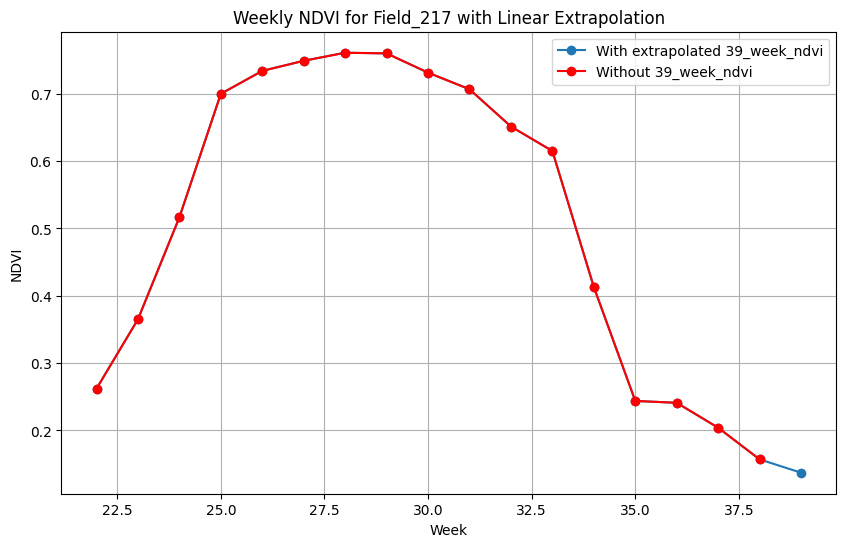

In [194]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


field_data = df_test[(df_test['Field'] == 500)]

# Data for extrapolation
weeks_for_extrapolation = [f"{i}_week_ndvi" for i in range(35, 39)]
weeks_full = [f"{i}_week_ndvi" for i in range(22, 40)]
ndvi_values = field_data[weeks_full].mean()

# Get data ready
x = np.array(range(35, 39))  # Weeks
y = ndvi_values[weeks_for_extrapolation].values  # Values NDVI

#  (slope и intercept)
slope, intercept = np.polyfit(x, y, 1)

# Extrapolation
x_new = 39
y_new = slope * x_new + intercept

# Update data
ndvi_values['39_week_ndvi'] = y_new

# Viz with  '39_week_ndvi'
plt.figure(figsize=(10, 6))
plt.plot(range(22, 40), ndvi_values, marker='o', linestyle='-', label='With extrapolated 39_week_ndvi')
plt.title('Weekly NDVI for Field_217 with Linear Extrapolation')
plt.xlabel('Week')
plt.ylabel('NDVI')
plt.grid(True)

# Viz NDVI without '39_week_ndvi'
ndvi_values_no_39 = ndvi_values.drop('39_week_ndvi')
plt.plot(range(22, 39), ndvi_values_no_39, marker='o', linestyle='-', label='Without 39_week_ndvi', color='red')
plt.legend()
plt.show()


In [195]:
def linear_extrapolation(row):
    # Извлечение значений NDVI за последние 4 недели
    x = np.array([35, 36, 37, 38])
    y = row[['35_week_ndvi', '36_week_ndvi', '37_week_ndvi', '38_week_ndvi']].values
    
    # Вычисление наклона и пересечения
    slope, intercept = np.polyfit(x, y, 1)
    
    # Экстраполяция значения на 39 неделе
    return slope * 39 + intercept

# Применение функции экстраполяции к каждой строке датасета
df_test['39_week_ndvi'] = df_test.apply(linear_extrapolation, axis=1)


Because of:

  - the model must be stable for each harvest year (task description)
  - I will not be able to include the categorical characteristics Year_2016....Year_2020 in the dataframe (for the last year, all values will be zero, which loses the meaning of this variable)
  - I will not be able to create a new variable based on Year - the previous year's yield for a given field, since we do not have complete data for each year for each field, and also we will not have this data for the entire 2016, since we do not have data for 2015

I decide to exclude this feature when building the model.

In [196]:
df_train.drop('Year', axis=1, inplace=True)
df_test.drop('Year', axis=1, inplace=True)
df_train.shape, df_test.shape

((5561, 237), (2187, 237))

In [197]:
list(df_train.columns) == list(df_test.columns)

True

In [199]:
df_train.to_csv(r'F:\DS\Kernel\data\train_clean.csv', index=False, sep=',')
df_test.to_csv(r'F:\DS\Kernel\data\test_clean.csv', index=False, sep=',')

Thus, I brought all the features into the correct format, the identifiers resulted in a sparse matrix, encoded the categories, filled in the missing values and carried out a logarithmic transformation of some features with outliers.
At the end, I checked the test and training sets for feature identity and saved the prepared datasets for further modeling.